## Defensive Attributes 
- Defensive Ability: Tackle % (Tackles_Won/Tackles), Dribblers_Tackled_Successfully_Percent, Successful_Pressures_Percent, Shots_Blocked/Total_Shots /90, Interceptions/(Passes Attempted Against)/90, Reliability (1/errors/touches in def 3rd)
- Build-Up Value: xA_per_90, Pass_Completion_Percent, Completed_Passes_into_Att_Third, Total_Pass_Progressive_Distance /90, Passes_Made_Under_Pressure, Shot_Creating_Actions_per_90, Successful_Dribbles_Percent, Progressive_Distance_of_Carries/90
- Aerial Ability:  Aerial_Duels_Won_Percent,Aerial_Duels_Won + Aerial_Duels_Lost, Passes_Made_With_Head/90, xG_Per_90

All metrics make use of minutes (nineties played )

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import ternary 
import sqlite3
import functools as ft
import math
from adjustText import adjust_text
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.patches as patches
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
conn = sqlite3.connect(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\soccer_data.db")

In [3]:
positions = pd.read_csv(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Transfermarket\positions.csv")
positions = positions[positions['Position'] == 'Centre-Back']['Player'].tolist()
player_lst= pd.read_sql("Select Player from Players_Data WHERE Position ='DF' AND Competition_Name ='Premier League' AND Minutes_Played > 1000",conn)['Player'].to_list()
player_lst = tuple([x for x in player_lst if x in positions])

In [8]:
query = f"SELECT Player,Squad ,Nineties, Tackles_Won, Tackles, Dribblers_Tackled_Successfully_Percent, Successful_Pressures_Percent, Shots_Blocked,Interceptions FROM Players_Data WHERE player in{player_lst}"
player = pd.read_sql(query,conn)
player = player[player['Nineties'] > 20]
against = pd.read_sql(f"SELECT Squad, Matches_Played ,Total_Shots, Passes_Attempted from Against_Squad_Data WHERE Squad in {tuple(player['Squad'].tolist())} ",conn)
against.columns = ['Squad_Against','Matches_Played','Total_Shots_Against','Passes_Attempted_Against']
player = pd.merge(player,against, how='left',left_on='Squad',right_on='Squad_Against')
working_df = player[['Player','Squad' ,'Nineties','Dribblers_Tackled_Successfully_Percent','Successful_Pressures_Percent']]
working_df['Tackle %'] = player['Tackles_Won']/player['Tackles'] * 100
working_df['Blocked%'] = (player['Shots_Blocked']/player['Nineties']) / (player['Total_Shots_Against']/player['Matches_Played'])*100
working_df['Interceptions %'] = (player['Interceptions']/player['Nineties'])/(player['Passes_Attempted_Against']/player['Matches_Played'])*100
final = player[['Player','Squad']]
cols = working_df.columns[2:].to_list()
for col in cols:
    final[col]= (working_df[col]-working_df[col].mean())/working_df[col].std(ddof=0)
    final[col] = (final[col]-final[col].min())/(final[col].max()-final[col].min()) * 100
final['Def'] = final['Dribblers_Tackled_Successfully_Percent'] *0.25 + final['Tackle %'] * 0.25 + final['Successful_Pressures_Percent'] *0.15 + final['Blocked%'] *0.1  + final['Interceptions %'] * 0.1 + final['Nineties']*0.10
final['Def'] = final['Def'].rank(pct=True)*100
present = final[['Player','Squad','Def']]

In [4]:
def get_defensive_ability(player_lst):
    query = f"SELECT Player,Squad ,Nineties, Tackles_Won, Tackles, Dribblers_Tackled_Successfully_Percent, Successful_Pressures_Percent, Shots_Blocked,Interceptions FROM Players_Data WHERE player in{player_lst}"
    player = pd.read_sql(query,conn)
    player = player[player['Nineties'] > 20]
    against = pd.read_sql(f"SELECT Squad, Matches_Played ,Total_Shots, Passes_Attempted from Against_Squad_Data WHERE Squad in {tuple(player['Squad'].tolist())} ",conn)
    against.columns = ['Squad_Against','Matches_Played','Total_Shots_Against','Passes_Attempted_Against']
    player = pd.merge(player,against, how='left',left_on='Squad',right_on='Squad_Against')
    working_df = player[['Player','Squad' ,'Nineties','Dribblers_Tackled_Successfully_Percent','Successful_Pressures_Percent']]
    working_df['Tackle %'] = player['Tackles_Won']/player['Tackles'] * 100
    working_df['Blocked%'] = (player['Shots_Blocked']/player['Nineties']) / (player['Total_Shots_Against']/player['Matches_Played'])*100
    working_df['Interceptions %'] = (player['Interceptions']/player['Nineties'])/(player['Passes_Attempted_Against']/player['Matches_Played'])*100
    final = player[['Player','Squad']]
    cols = working_df.columns[2:].to_list()
    for col in cols:
        final[col]= (working_df[col]-working_df[col].mean())/working_df[col].std(ddof=0)
        final[col] = (final[col]-final[col].min())/(final[col].max()-final[col].min()) * 100
    final['Def'] = final['Dribblers_Tackled_Successfully_Percent'] *0.25 + final['Tackle %'] * 0.25 + final['Successful_Pressures_Percent'] *0.15 + final['Blocked%'] *0.1  + final['Interceptions %'] * 0.1 + final['Nineties']*0.10
    final['Def'] = final['Def'].rank(pct=True)*100
    present = final[['Player','Squad','Def']]
    return present

In [11]:
def get_bpa(player_lst):
    query = f"SELECT Player,Squad ,Nineties, xA_per_90, Pass_Completion_Percent, Completed_Passes_into_Att_Third, Total_Pass_Progressive_Distance, Passes_Made_Under_Pressure, Shot_Creating_Actions_per_90, Successful_Dribbles_Percent, Progressive_Distance_of_Carries FROM Players_Data WHERE player in{player_lst}"
    player = pd.read_sql(query,conn)
    player = player[player['Nineties'] > 20]
    player['Total_Pass_Progressive_Distance_per_90'] = player['Total_Pass_Progressive_Distance']/player['Nineties']
    player['Progressive_Distance_of_Carries_per_90'] = player['Progressive_Distance_of_Carries']/player['Nineties']
    player.drop(['Total_Pass_Progressive_Distance','Progressive_Distance_of_Carries'],axis=1,inplace=True)
    player['Completed_Passes_into_Att_Third_90'] = player['Completed_Passes_into_Att_Third']/player['Nineties']
    player['Passes_Made_Under_Pressure_per_90'] = player['Passes_Made_Under_Pressure']/player['Nineties']
    final = player[['Player','Squad']]
    cols = player.columns[2:].to_list()
    for col in cols:
        final[col]= (player[col]-player[col].mean())/player[col].std(ddof=0)
        final[col] = (final[col]-final[col].min())/(final[col].max()-final[col].min()) * 100
    final['BPA'] = final['Nineties']*0.1 + final['xA_per_90'] * 0.05 + final['Pass_Completion_Percent'] * 0.15 + final['Completed_Passes_into_Att_Third_90'] * 0.15 + final['Passes_Made_Under_Pressure_per_90'] * 0.1 + final['Shot_Creating_Actions_per_90']*0.1 + final['Successful_Dribbles_Percent']*0.05 + final['Total_Pass_Progressive_Distance_per_90'] * 0.15 + final['Progressive_Distance_of_Carries_per_90']*0.15
    final['BPA'] = final['BPA'].rank(pct=True)*100
    present = final[['Player','Squad','BPA']]
    return present

In [6]:
def get_aerial(player_lst):
    query = f"SELECT Player,Squad ,Nineties,Aerial_Duels_Won_Percent,Aerial_Duels_Won,Aerial_Duels_Lost, Passes_Made_With_Head, xG_per_90 FROM Players_Data WHERE player in{player_lst}"
    player = pd.read_sql(query,conn)
    player = player[player['Nineties'] > 20]
    player['Passes_Made_With_Head_per_90'] = player['Passes_Made_With_Head']/player['Nineties']
    player['Aerial_Duels'] = player[['Aerial_Duels_Won','Aerial_Duels_Lost']].sum(axis=1)
    player.drop(['Passes_Made_With_Head','Aerial_Duels_Won','Aerial_Duels_Lost'],axis=1,inplace=True)
    final = player[['Player','Squad']]
    cols = player.columns[2:].to_list()
    for col in cols:
        final[col]= (player[col]-player[col].mean())/player[col].std(ddof=0)
        final[col] = (final[col]-final[col].min())/(final[col].max()-final[col].min()) * 100
    final['Aerial'] = final['Nineties'] * 0.1 + final['Aerial_Duels_Won_Percent'] * 0.4 + final['Aerial_Duels'] *0.3 + final['Passes_Made_With_Head_per_90']*0.05 + final['xG_per_90'] * 0.15
    final['Aerial'] = final['Aerial'].rank(pct=True)*100
    present = final[['Player','Squad','Aerial']]
    return present

In [7]:
df

NameError: name 'df' is not defined

In [297]:
df = ft.reduce(lambda left, right: pd.merge(left, right, on=['Player','Squad']), [get_defensive_ability(player_lst),get_bpa(player_lst),get_aerial(player_lst)])
cols = ['Def','BPA','Aerial']
for col in cols:
    df[col[0]] = df[col] * 100 / df[cols].sum(axis=1) #normalize

In [ ]:
#Styles
bg_color = '#EEE0CB'
edge_color = 'black'
edge_color = {'l':edge_color,'r':edge_color,'b':edge_color}
point_color = '#280003'
corner_color = 'black'
title_color = 'black'
corner_size = 15
title_size = 35
title_font = 'Helvetica'
player_size = 10
player_color = '#C2847A'
point_size = 15

#figure
fig, ax = plt.subplots()
ax.axis('off')
fig.set_size_inches(20,16)
fig.patch.set_facecolor(bg_color)

#ternary
figure, tax = ternary.figure(ax=ax,scale=100)
tax.set_background_color(bg_color)
tax.boundary(axes_colors=edge_color)
tax.scatter(df[['D','B','A']].values,c=point_color,s=point_size)

#labels
names = []
for i,txt in enumerate(df['Player'].tolist()):
    x = ternary.project_point((df['D'].iloc[i],df['B'].iloc[i],df['A'].iloc[i]))[0]
    y = ternary.project_point((df['D'].iloc[i],df['B'].iloc[i],df['A'].iloc[i]))[1]
    names.append(plt.text(x,y,txt,c=player_color,fontsize=player_size))
adjust_text(names,arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

#corner
tax.right_corner_label('Defensive Ability',position=(0.97,0.11),c=corner_color,fontsize= corner_size)
tax.top_corner_label('Ball-Playing Ability',offset=0.15,c=corner_color,fontsize= corner_size)
tax.left_corner_label('Aerial Ability',position=(-0.07,0.11),c=corner_color,fontsize= corner_size)


#padding


#title
#fig.text(0.075,0.95,'The Modern Centre Back',ha='left',fontsize =title_size,c=title_color,fontfamily=title_font)

In [ ]:
df = ft.reduce(lambda left, right: pd.merge(left, right, on=['Player','Squad']), [get_defensive_ability(player_lst),get_bpa(player_lst),get_aerial(player_lst)])

In [337]:
1/math.sqrt(2)

0.7071067811865475

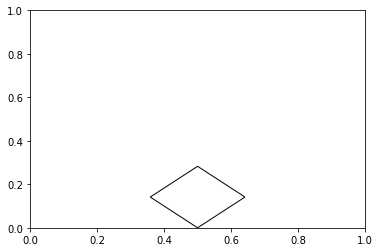

In [380]:
fig,axs =plt.subplots()
rect = patches.Rectangle((0.5,0),0.2,0.2,angle=45,facecolor='none',edgecolor='black')
axs.add_patch(rect)


NameError: name 'df' is not defined

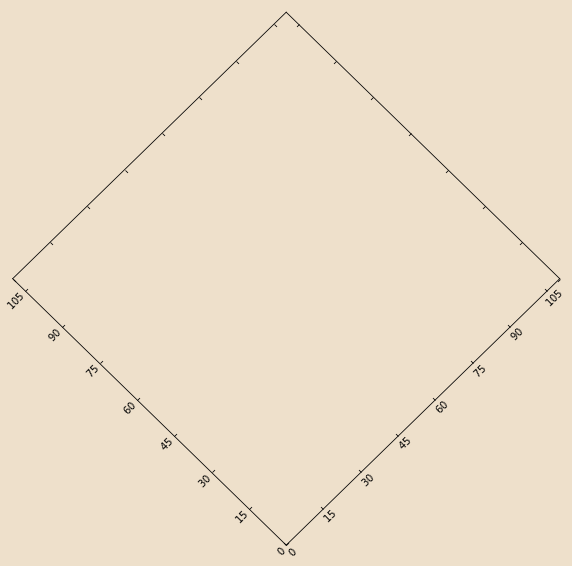

In [12]:
def setup_axes1(fig, rect):

    tr = Affine2D().scale(2, 2).rotate_deg(45)

    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(0, 110, 0, 110))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    aux_ax = ax1.get_aux_axes(tr)
    # for key in ax1.axis:
    #     ax1.axis[key].set_visible(False)
    return ax1, aux_ax


#Styles
bg_color = '#EEE0CB'


#figure
fig = plt.figure()
fig.set_size_inches(20,16)
fig.patch.set_facecolor(bg_color)
ax1, aux_ax1 = setup_axes1(fig, 111)

ax1.set_facecolor(bg_color)
fig.set_size_inches(10,10)
ax1.set_aspect('equal', 'box')
aux_ax1.scatter(df['Def'],df['BPA'])
ax1.grid(color='r', linestyle='-', linewidth=0.5)


In [368]:
ax1.axis['top'].aix

AttributeError: 'AxisArtist' object has no attribute 'ticks'